<a href="https://colab.research.google.com/github/Putra1688/MachineLearning-2025-22/blob/main/UTS/HousePrice_K_Means_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0) Persiapan Awal**

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from annoy import AnnoyIndex



In [35]:
!pip install annoy

# **1) Load Data**

In [36]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/train.csv')

# Tampilkan informasi dasar untuk orientasi
print(df_train.info())

# Drop kolom 'Id' dan 'SalePrice' karena tidak relevan untuk clustering
df_data = df_train.drop(['Id', 'SalePrice'], axis=1, errors='ignore')

print("\nDataFrame yang siap untuk preprocessing (df_data.head()):")
print(df_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [37]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/test.csv')

train_len = len(df_train)
test_ids = df_test['Id']

# Kita hanya menggunakan fitur untuk clustering, jadi SalePrice harus di-drop dulu dari train
features = df_train.drop(['Id', 'SalePrice'], axis=1)
df_test_features = df_test.drop('Id', axis=1) # test.csv memang tidak punya SalePrice

df_data_combined = pd.concat([features, df_test_features], ignore_index=True)

# Lanjutkan dengan df_data_combined sebagai input untuk Feature Engineering
df_data = df_data_combined # Ganti nama variabel agar sesuai dengan kode berikutnya
print(f"Data Gabungan (Train + Test) Berhasil. Total Baris: {len(df_data)}")

Data Gabungan (Train + Test) Berhasil. Total Baris: 2919


# **2) Preprocessing Data**

## **2.1) Pemisahan Tipe Data**

In [38]:
# 1. Kolom yang pasti numerik dan akan di-imputasi dengan mean/median
numerical_cols = df_data.select_dtypes(include=np.number).columns.tolist()

# 2. Kolom yang pasti kategorikal (nominal) dan akan di-One-Hot Encode
# Asumsi: Kita ambil yang tipe 'object'
categorical_cols = df_data.select_dtypes(include='object').columns.tolist()

# Karena datanya sangat banyak, mari kita fokuskan pada subset fitur
# yang paling penting untuk cluster (berdasarkan pengalaman EDA data ini):
features_for_clustering = ['MSZoning', 'Neighborhood', 'LotArea', 'LotShape', 'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea',
                           '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr','BldgType', 'KitchenQual',
                           'TotalBsmtSF', 'BsmtFinSF1', 'GarageCars', 'GarageArea' , 'PoolQC', 'Fence' ]

# Filter kolom yang akan dipakai
df_subset = df_data[features_for_clustering]

# Tentukan ulang kolom berdasarkan subset:
numerical_cols_subset = df_subset.select_dtypes(include=np.number).columns.tolist()
categorical_cols_subset = df_subset.select_dtypes(include='object').columns.tolist()

## **2.2) Membuat Fitur Baru (Feature Engineering)**

In [39]:
# Tambahkan fitur baru 'TotalSF'
# Catatan: Kita harus bekerja pada df_data asli yang memiliki kolom 1stFlrSF dan 2ndFlrSF
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Perbarui daftar fitur clustering untuk memasukkan TotalSF
features_for_clustering_final = features_for_clustering + ['TotalSF']

df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Contoh Imputasi (PENTING: Harus dijalankan di df_data)
cols_none_cat = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
for col in cols_none_cat:
    df_data[col] = df_data[col].fillna('None')

# Filter ulang subset data dan daftar kolom numerik/kategorikal
df_subset_final = df_data[features_for_clustering_final]
numerical_cols_final = df_subset_final.select_dtypes(include=np.number).columns.tolist()
categorical_cols_final = df_subset_final.select_dtypes(include='object').columns.tolist()

In [40]:
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Contoh Imputasi (PENTING: Harus dijalankan di df_data)
cols_none_cat = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
for col in cols_none_cat:
    df_data[col] = df_data[col].fillna('None')

## **2.3) Penanganan Missing Values dan Encoding Menggunakan Pipeline**

In [41]:
# 1. Preprocessor for Numerical data: Impute with Median, then Standardize
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Preprocessor for Categorical data: Impute with Mode, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungkan preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_final),
        ('cat', categorical_transformer, categorical_cols_final)
    ])

# Terapkan Preprocessor pada data GABUNGAN (df_data)
# Pastikan df_data sudah memiliki fitur TotalSF dan imputasi None
X_final = preprocessor.fit_transform(df_data[features_for_clustering_final])


# Dapatkan nama fitur baru setelah One-Hot Encoding
feature_names = (numerical_cols_final +
                 list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols_final)))

# Koreksi Error: HAPUS .toarray()
X_df_processed = pd.DataFrame(X_final, columns=feature_names)

print("\n--- Data Setelah Imputasi, Encoding, dan Feature Engineering (X_df_processed.head()) ---")
print(X_df_processed.head())
print(f"Shape Data Setelah Preprocessing: {X_df_processed.shape}")


--- Data Setelah Imputasi, Encoding, dan Feature Engineering (X_df_processed.head()) ---
    LotArea  OverallQual  OverallCond  YearBuilt  GrLivArea  1stFlrSF  \
0 -0.217879     0.646183    -0.507284   1.046258   0.413547 -0.773861   
1 -0.072044    -0.063185     2.188279   0.154764  -0.471891  0.261075   
2  0.137197     0.646183    -0.507284   0.980221   0.563755 -0.610718   
3 -0.078385     0.646183    -0.507284  -1.859351   0.427382 -0.506205   
4  0.518903     1.355551    -0.507284   0.947203   1.378042 -0.037170   

   2ndFlrSF  FullBath  BedroomAbvGr  TotalBsmtSF  ...  KitchenQual_TA  \
0  1.207379  0.781366      0.169927    -0.444278  ...             0.0   
1 -0.785025  0.781366      0.169927     0.477158  ...             1.0   
2  1.235375  0.781366      0.169927    -0.299027  ...             0.0   
3  0.978742 -1.027363      0.169927    -0.671232  ...             0.0   
4  1.671651  0.781366      1.385655     0.211621  ...             0.0   

   PoolQC_Ex  PoolQC_Fa  PoolQC_

# **3) Clustering K-Means**

## **3.1) Menentukan Jumlah Cluster ($K$) Optimal**


--- Menghitung Metrik Kualitas Cluster untuk K=2 hingga K=10 ---
K=2: Silhouette=0.2145, DBI=1.7083
K=3: Silhouette=0.1972, DBI=1.8355
K=4: Silhouette=0.1720, DBI=1.8233
K=5: Silhouette=0.1503, DBI=2.0144
K=6: Silhouette=0.1370, DBI=2.0155
K=7: Silhouette=0.1406, DBI=1.7712
K=8: Silhouette=0.1373, DBI=1.8185
K=9: Silhouette=0.1314, DBI=1.8356
K=10: Silhouette=0.1358, DBI=1.8195


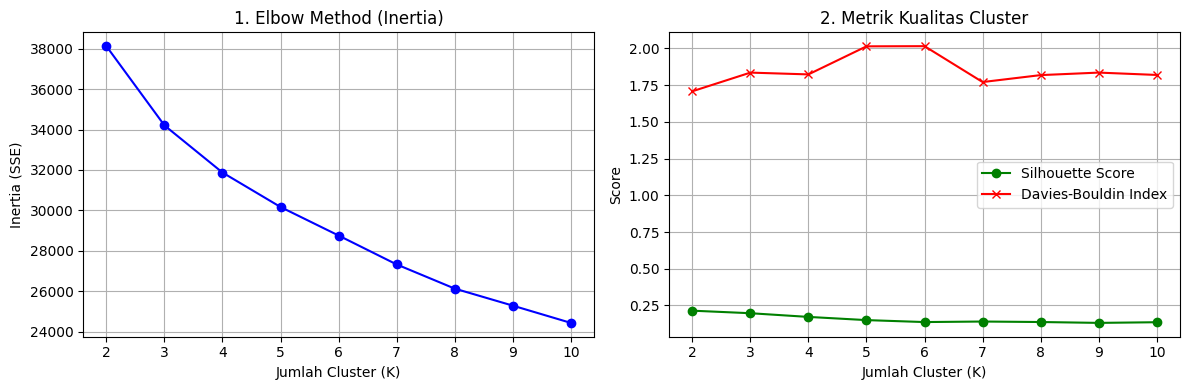

In [42]:
# Tentukan rentang K yang akan diuji
k_range = range(2, 11)
inertia = []
silhouette_scores = {}
davies_bouldin_scores = {}

print("\n--- Menghitung Metrik Kualitas Cluster untuk K=2 hingga K=10 ---")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_final)
    inertia.append(kmeans.inertia_)

    if k >= 2:
        # Menghitung skor untuk perbandingan
        silhouette_scores[k] = silhouette_score(X_final, kmeans.labels_)
        davies_bouldin_scores[k] = davies_bouldin_score(X_final, kmeans.labels_)
        print(f"K={k}: Silhouette={silhouette_scores[k]:.4f}, DBI={davies_bouldin_scores[k]:.4f}")

# Analisis visual untuk memilih K optimal
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o', color='blue')
plt.title('1. Elbow Method (Inertia)')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Inertia (SSE)')
plt.grid(True)

plt.subplot(1, 2, 2)
# Konversi dictionary skor ke list untuk plotting
silhouette_list = [silhouette_scores[k] for k in k_range]
dbi_list = [davies_bouldin_scores[k] for k in k_range]
plt.plot(k_range, silhouette_list, marker='o', color='green', label='Silhouette Score')
plt.plot(k_range, dbi_list, marker='x', color='red', label='Davies-Bouldin Index')
plt.title('2. Metrik Kualitas Cluster')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
#

# Setelah melihat grafik (misalnya, kita memilih K=5 karena memberikan keseimbangan skor)
K_optimal = 5

## **3.2) Menerapkan K-Means Akhir dan Evaluasi**


--- Menerapkan K-Means dengan K Optimal = 5 ---

✅ Clustering Berhasil!
Jumlah data train: 1460
Jumlah data test: 1459

Silhouette Score Akhir: 0.1503
Davies-Bouldin Index Akhir: 2.0144

📊 VISUALISASI HASIL CLUSTERING


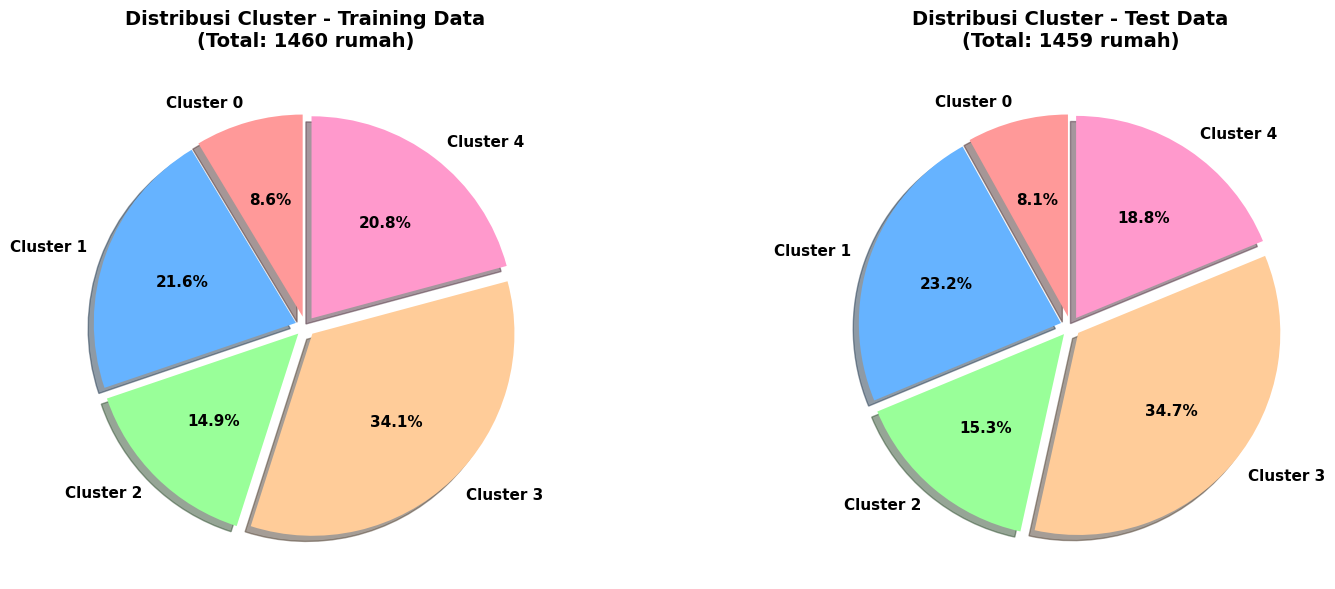

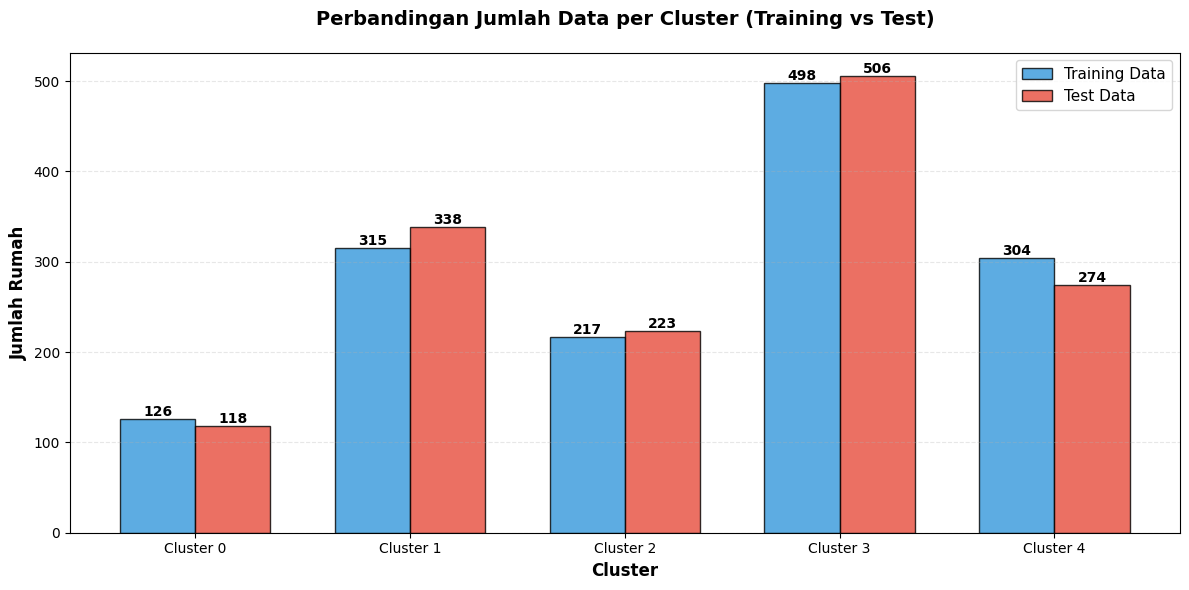


📋 TABEL RINGKASAN DISTRIBUSI CLUSTER
 Cluster  Training Count Training %  Test Count Test %  Total
       0             126       8.6%         118   8.1%    244
       1             315      21.6%         338  23.2%    653
       2             217      14.9%         223  15.3%    440
       3             498      34.1%         506  34.7%   1004
       4             304      20.8%         274  18.8%    578


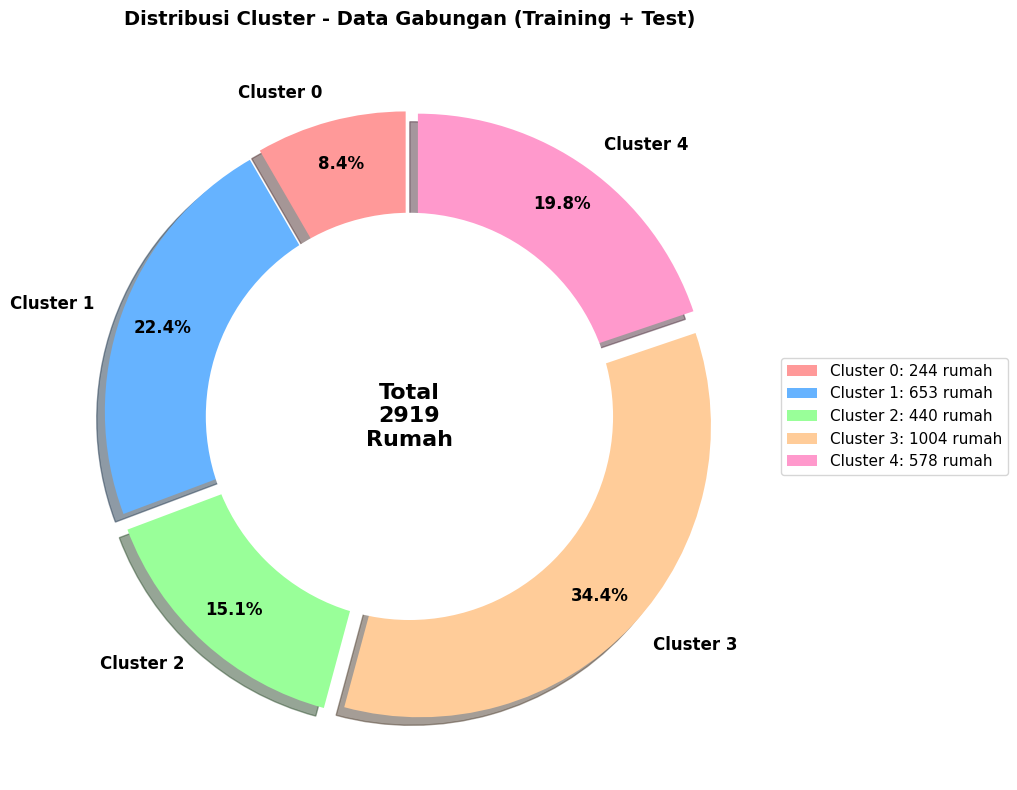


🎉 VISUALISASI CLUSTERING SELESAI!


In [43]:
print(f"\n--- Menerapkan K-Means dengan K Optimal = {K_optimal} ---")

# Lakukan clustering pada data yang sudah digabung
kmeans_final = KMeans(n_clusters=K_optimal, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_final)

# PENTING: Pisahkan cluster_labels untuk train dan test
train_cluster_labels = cluster_labels[:train_len]  # 1460 baris pertama untuk train
test_cluster_labels = cluster_labels[train_len:]   # Sisanya untuk test

# Tambahkan label cluster ke df_train (SEKARANG PANJANGNYA COCOK!)
df_train['Cluster'] = train_cluster_labels

# Buat DataFrame untuk test dengan cluster labels
df_test_with_clusters = pd.DataFrame({
    'Id': test_ids,
    'Cluster': test_cluster_labels
})

# Tampilkan metrik akhir (menggunakan SEMUA data untuk konsistensi)
final_silhouette = silhouette_score(X_final, cluster_labels)
final_davies_bouldin = davies_bouldin_score(X_final, cluster_labels)

print(f"\n✅ Clustering Berhasil!")
print(f"Jumlah data train: {len(train_cluster_labels)}")
print(f"Jumlah data test: {len(test_cluster_labels)}")
print(f"\nSilhouette Score Akhir: {final_silhouette:.4f}")
print(f"Davies-Bouldin Index Akhir: {final_davies_bouldin:.4f}")

# ========== VISUALISASI HASIL CLUSTERING ==========
print("\n" + "="*80)
print("📊 VISUALISASI HASIL CLUSTERING")
print("="*80)

# 1. PIE CHART - Distribusi Cluster di Training Data
cluster_counts_train = df_train['Cluster'].value_counts().sort_index()
cluster_counts_test = df_test_with_clusters['Cluster'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie Chart untuk Training Data
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
explode = [0.05] * K_optimal  # Membuat jarak antar slice

axes[0].pie(cluster_counts_train, labels=[f'Cluster {i}' for i in range(K_optimal)],
            autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,
            shadow=True, textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Distribusi Cluster - Training Data\n(Total: {} rumah)'.format(len(df_train)),
                  fontsize=14, weight='bold', pad=20)

# Pie Chart untuk Test Data
axes[1].pie(cluster_counts_test, labels=[f'Cluster {i}' for i in range(K_optimal)],
            autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,
            shadow=True, textprops={'fontsize': 11, 'weight': 'bold'})
axes[1].set_title('Distribusi Cluster - Test Data\n(Total: {} rumah)'.format(len(df_test_with_clusters)),
                  fontsize=14, weight='bold', pad=20)

plt.tight_layout()
plt.show()

# 2. BAR CHART - Perbandingan Jumlah Data per Cluster
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(K_optimal)
width = 0.35

bars1 = ax.bar(x - width/2, cluster_counts_train, width, label='Training Data',
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, cluster_counts_test, width, label='Test Data',
               color='#e74c3c', alpha=0.8, edgecolor='black')

# Tambahkan nilai di atas bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, weight='bold')

ax.set_xlabel('Cluster', fontsize=12, weight='bold')
ax.set_ylabel('Jumlah Rumah', fontsize=12, weight='bold')
ax.set_title('Perbandingan Jumlah Data per Cluster (Training vs Test)',
             fontsize=14, weight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([f'Cluster {i}' for i in range(K_optimal)])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 3. TABEL RINGKASAN
print("\n" + "="*80)
print("📋 TABEL RINGKASAN DISTRIBUSI CLUSTER")
print("="*80)

summary_df = pd.DataFrame({
    'Cluster': range(K_optimal),
    'Training Count': cluster_counts_train.values,
    'Training %': [f"{(count/len(df_train)*100):.1f}%" for count in cluster_counts_train.values],
    'Test Count': cluster_counts_test.values,
    'Test %': [f"{(count/len(df_test_with_clusters)*100):.1f}%" for count in cluster_counts_test.values],
    'Total': cluster_counts_train.values + cluster_counts_test.values
})

print(summary_df.to_string(index=False))
print("="*80)

# 4. DONUT CHART - Distribusi Gabungan (Training + Test)
total_cluster_counts = cluster_counts_train + cluster_counts_test

fig, ax = plt.subplots(figsize=(10, 8))

wedges, texts, autotexts = ax.pie(total_cluster_counts,
                                    labels=[f'Cluster {i}' for i in range(K_optimal)],
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors,
                                    explode=explode,
                                    shadow=True,
                                    textprops={'fontsize': 12, 'weight': 'bold'},
                                    pctdistance=0.85)

# Buat donut chart dengan membuat circle di tengah
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Tambahkan teks di tengah
ax.text(0, 0, f'Total\n{len(df_train) + len(df_test_with_clusters)}\nRumah',
        ha='center', va='center', fontsize=16, weight='bold')

ax.set_title('Distribusi Cluster - Data Gabungan (Training + Test)',
             fontsize=14, weight='bold', pad=20)

# Tambahkan legend dengan jumlah
legend_labels = [f'Cluster {i}: {total_cluster_counts[i]} rumah' for i in range(K_optimal)]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=11)

plt.tight_layout()
plt.show()

print("\n🎉 VISUALISASI CLUSTERING SELESAI!")
print("="*80)

## **3.3) Interpretasi (Analisis Profil Cluster)**


📊 ANALISIS PROFIL SETIAP CLUSTER (Berdasarkan Data Training)

🏘️  CLUSTER 0 - Total: 126 rumah (8.6%)

💰 HARGA JUAL (SalePrice):
   - Rata-rata: $349,953
   - Median   : $335,000
   - Min      : $160,000
   - Max      : $755,000

🏠 KARAKTERISTIK FISIK:
   - Luas Tanah (LotArea)    : 20,317 sq ft (rata-rata)
   - Luas Bangunan (GrLivArea): 2,405 sq ft (rata-rata)
   - Total SF (TotalSF)      : 4,177 sq ft (rata-rata)
   - Tahun Dibangun          : 2003 (median)
   - Overall Quality         : 8.2/10 (rata-rata)

🚗 GARASI:
   - Kapasitas Mobil: 2.8 mobil (rata-rata)

📍 LOKASI (Neighborhood Terpopuler):
   1. NridgHt: 39 rumah (31.0%)
   2. NoRidge: 24 rumah (19.0%)
   3. Timber: 13 rumah (10.3%)

🗺️  ZONA (MSZoning Terpopuler):
   1. RL: 122 rumah (96.8%)
   2. RM: 3 rumah (2.4%)

🏘️  CLUSTER 1 - Total: 315 rumah (21.6%)

💰 HARGA JUAL (SalePrice):
   - Rata-rata: $206,751
   - Median   : $197,000
   - Min      : $82,500
   - Max      : $392,500

🏠 KARAKTERISTIK FISIK:
   - Luas Tanah (Lo

<Figure size 1200x600 with 0 Axes>

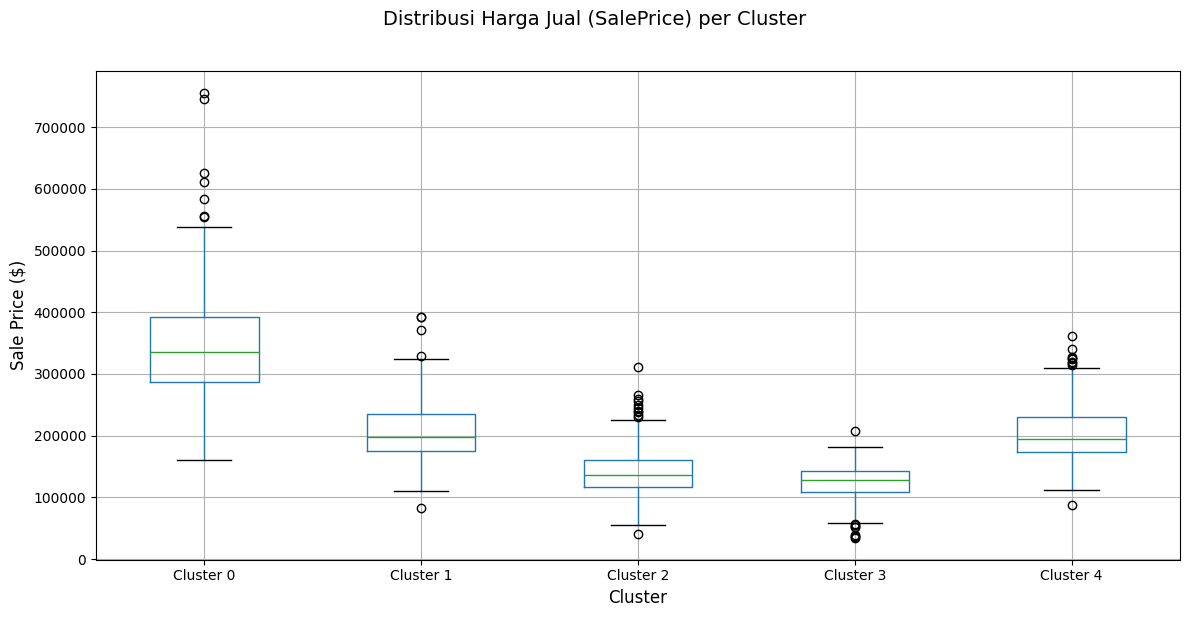

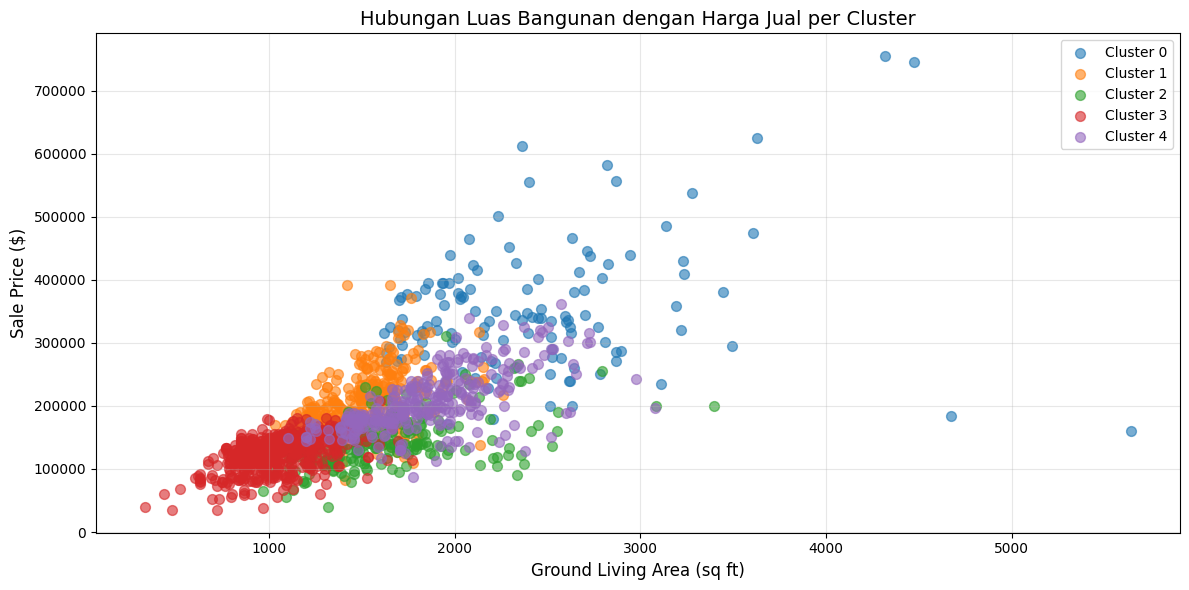

In [44]:
print("\n" + "="*80)
print("📊 ANALISIS PROFIL SETIAP CLUSTER (Berdasarkan Data Training)")
print("="*80)

# Add TotalSF to df_train for interpretation
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

# Statistik deskriptif untuk setiap cluster
for cluster_id in range(K_optimal):
    cluster_data = df_train[df_train['Cluster'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"🏘️  CLUSTER {cluster_id} - Total: {len(cluster_data)} rumah ({len(cluster_data)/len(df_train)*100:.1f}%)")
    print(f"{'='*80}")

    # Statistik SalePrice
    print(f"\n💰 HARGA JUAL (SalePrice):")
    print(f"   - Rata-rata: ${cluster_data['SalePrice'].mean():,.0f}")
    print(f"   - Median   : ${cluster_data['SalePrice'].median():,.0f}")
    print(f"   - Min      : ${cluster_data['SalePrice'].min():,.0f}")
    print(f"   - Max      : ${cluster_data['SalePrice'].max():,.0f}")

    # Karakteristik fisik rumah
    print(f"\n🏠 KARAKTERISTIK FISIK:")
    print(f"   - Luas Tanah (LotArea)    : {cluster_data['LotArea'].mean():,.0f} sq ft (rata-rata)")
    print(f"   - Luas Bangunan (GrLivArea): {cluster_data['GrLivArea'].mean():,.0f} sq ft (rata-rata)")
    print(f"   - Total SF (TotalSF)      : {cluster_data['TotalSF'].mean():,.0f} sq ft (rata-rata)")
    print(f"   - Tahun Dibangun          : {cluster_data['YearBuilt'].median():.0f} (median)")
    print(f"   - Overall Quality         : {cluster_data['OverallQual'].mean():.1f}/10 (rata-rata)")

    # Informasi garasi
    print(f"\n🚗 GARASI:")
    print(f"   - Kapasitas Mobil: {cluster_data['GarageCars'].mean():.1f} mobil (rata-rata)")

    # Neighborhood paling umum
    print(f"\n📍 LOKASI (Neighborhood Terpopuler):")
    top_neighborhoods = cluster_data['Neighborhood'].value_counts().head(3)
    for idx, (neighborhood, count) in enumerate(top_neighborhoods.items(), 1):
        print(f"   {idx}. {neighborhood}: {count} rumah ({count/len(cluster_data)*100:.1f}%)")

    # Zoning paling umum
    print(f"\n🗺️  ZONA (MSZoning Terpopuler):")
    top_zoning = cluster_data['MSZoning'].value_counts().head(2)
    for idx, (zone, count) in enumerate(top_zoning.items(), 1):
        print(f"   {idx}. {zone}: {count} rumah ({count/len(cluster_data)*100:.1f}%)")

print("\n" + "="*80)
print("✅ ANALISIS SELESAI!")
print("="*80)

# Visualisasi tambahan: Boxplot SalePrice per Cluster
plt.figure(figsize=(12, 6))
df_train.boxplot(column='SalePrice', by='Cluster', figsize=(12, 6))
plt.suptitle('Distribusi Harga Jual (SalePrice) per Cluster', fontsize=14, y=1.02)
plt.title('')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Sale Price ($)', fontsize=12)
plt.xticks(range(1, K_optimal+1), [f'Cluster {i}' for i in range(K_optimal)])
plt.tight_layout()
plt.show()

# Scatter plot: GrLivArea vs SalePrice dengan warna cluster
plt.figure(figsize=(12, 6))
for cluster_id in range(K_optimal):
    cluster_data = df_train[df_train['Cluster'] == cluster_id]
    plt.scatter(cluster_data['GrLivArea'], cluster_data['SalePrice'],
                label=f'Cluster {cluster_id}', alpha=0.6, s=50)
plt.xlabel('Ground Living Area (sq ft)', fontsize=12)
plt.ylabel('Sale Price ($)', fontsize=12)
plt.title('Hubungan Luas Bangunan dengan Harga Jual per Cluster', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# **4) Approximate Nearest Neighbor (ANN) dengan Annoy**

## **4.1) Building Annoy Index**

In [45]:
from annoy import AnnoyIndex

# Dimensi data (jumlah fitur setelah One-Hot Encoding dan Scaling)
f = X_final.shape[1]
print(f"\nJumlah Fitur (Dimensi) untuk Annoy Index: {f}")
print(f"Jumlah Total Data Points: {X_final.shape[0]}")

# 1. Inisialisasi Annoy Index
# 'f' adalah jumlah dimensi (fitur), 'angular' adalah metrik jarak yang umum digunakan
t = AnnoyIndex(f, 'angular')
num_trees = 10  # Hyperparameter: Jumlah pohon (semakin banyak semakin akurat, namun semakin lambat membangunnya)

# 2. Menambahkan item ke index
for i in range(X_final.shape[0]):
    t.add_item(i, X_final[i])

# 3. Membangun index
print(f"Membangun Annoy Index dengan {num_trees} pohon...")
t.build(num_trees)

print("✅ Annoy Index Berhasil Dibangun!")


Jumlah Fitur (Dimensi) untuk Annoy Index: 66
Jumlah Total Data Points: 2919
Membangun Annoy Index dengan 10 pohon...
✅ Annoy Index Berhasil Dibangun!


## **4.2) Selecting Query Points**

In [46]:
# Query Points: Pilih beberapa indeks rumah dari data training (0-1459)
# Contoh: Rumah dengan index 0, 10, 100, dan 1459 (last train index)
query_indices = [0, 10, 100, 1459]
num_neighbors = 5 # Jumlah tetangga terdekat yang ingin dicari

print(f"\n--- Mencari {num_neighbors} Tetangga Terdekat untuk Query Points ---")


--- Mencari 5 Tetangga Terdekat untuk Query Points ---


## **4.3) Searching Nearest Neighbors**

In [47]:
# Looping untuk setiap query point
for query_idx in query_indices:
    # Mengambil vektor fitur dari query point
    query_vector = X_final[query_idx]

    # Mencari tetangga terdekat
    # include_distances=True untuk mendapatkan nilai jarak (kemiripan)
    neighbor_indices, distances = t.get_nns_by_vector(
        query_vector,
        num_neighbors + 1, # +1 karena item pertama yang dikembalikan adalah query point itu sendiri
        include_distances=True
    )

    # Filter dan tampilkan hasil
    # Item pertama adalah query point itu sendiri, jadi kita lewati

    # 1. Ambil indeks dan jarak tetangga (lewatkan yang pertama)
    actual_neighbors = neighbor_indices[1:]
    actual_distances = distances[1:]

    print(f"\n========================================================")
    print(f"🔍 Query Point Index: {query_idx} (Data Asal: df_train[{query_idx}])")
    print(f"   Fitur Utama: OverallQual={df_train.loc[query_idx, 'OverallQual']}, GrLivArea={df_train.loc[query_idx, 'GrLivArea']}, SalePrice=${df_train.loc[query_idx, 'SalePrice']:,.0f}")
    print(f"========================================================")

    print(f"| Indeks Tetangga | Jarak (Angular) | Tipe Data | Kualitas (OQ) | Luas (SF) | Harga Jual |")
    print(f"|-----------------|-----------------|-----------|---------------|-----------|------------|")

    for n_idx, dist in zip(actual_neighbors, actual_distances):
        # Tentukan apakah tetangga berasal dari data 'train' atau 'test'
        data_type = 'Train' if n_idx < train_len else 'Test'
        df_index = n_idx if data_type == 'Train' else n_idx - train_len

        # Ambil SalePrice, OverallQual, dan GrLivArea untuk interpretasi
        if data_type == 'Train':
            price = f"${df_train.loc[n_idx, 'SalePrice']:,.0f}"
            qual = df_train.loc[n_idx, 'OverallQual']
            area = f"{df_train.loc[n_idx, 'GrLivArea']:,.0f}"
        else:
            # Data Test tidak memiliki SalePrice, ambil dari df_test_features
            price = "N/A"
            qual = df_test_features.loc[df_index, 'OverallQual']
            area = f"{df_test_features.loc[df_index, 'GrLivArea']:,.0f}"

        print(f"| {n_idx:<15} | {dist:<15.4f} | {data_type:<9} | {qual:<13} | {area:<9} | {price:<10} |")

print("\n🎉 Proses ANN Selesai!")


🔍 Query Point Index: 0 (Data Asal: df_train[0])
   Fitur Utama: OverallQual=7, GrLivArea=1710, SalePrice=$208,500
| Indeks Tetangga | Jarak (Angular) | Tipe Data | Kualitas (OQ) | Luas (SF) | Harga Jual |
|-----------------|-----------------|-----------|---------------|-----------|------------|
| 1240            | 0.1128          | Train     | 7             | 1,768     | $224,900   |
| 590             | 0.1953          | Train     | 7             | 1,582     | $185,900   |
| 2521            | 0.2106          | Test      | 7             | 1,842     | N/A        |
| 1410            | 0.2219          | Train     | 7             | 1,840     | $230,000   |
| 2531            | 0.2331          | Test      | 7             | 1,932     | N/A        |

🔍 Query Point Index: 10 (Data Asal: df_train[10])
   Fitur Utama: OverallQual=5, GrLivArea=1040, SalePrice=$129,500
| Indeks Tetangga | Jarak (Angular) | Tipe Data | Kualitas (OQ) | Luas (SF) | Harga Jual |
|-----------------|-----------------|---